In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
from patsy import dmatrices
from pandas import Series
from matplotlib import pyplot
from datetime import datetime
from matplotlib.pyplot import figure

import statsmodels.api as sm

figure(num=None, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='k')

from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing, Holt

import sys
import warnings
import itertools
warnings.filterwarnings("ignore")


import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

from statsmodels.tsa.stattools import adfuller


from statsmodels.tsa.arima_model import ARIMA

<Figure size 1280x960 with 0 Axes>

In [3]:
dt_1 = pd.read_csv('../input/crimes-in-chicago/Chicago_Crimes_2001_to_2004.csv' , error_bad_lines=False)
dt_2 = pd.read_csv('../input/crimes-in-chicago/Chicago_Crimes_2005_to_2007.csv' , error_bad_lines=False)
dt_3 = pd.read_csv('../input/crimes-in-chicago/Chicago_Crimes_2008_to_2011.csv' , error_bad_lines=False)
dt_4 = pd.read_csv('../input/crimes-in-chicago/Chicago_Crimes_2012_to_2017.csv' , error_bad_lines=False)

dt = pd.concat([dt_1,dt_2,dt_3,dt_4] , ignore_index=False , axis=0)

del dt_1
del dt_2
del dt_3
del dt_4

dt.shape

b'Skipping line 1513591: expected 23 fields, saw 24\n'
b'Skipping line 533719: expected 23 fields, saw 24\n'
b'Skipping line 1149094: expected 23 fields, saw 41\n'


(7941282, 23)

## Data Overview

In [4]:
dt= dt.drop_duplicates()

In [5]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
dt.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,6200659.000,3102108.699,1797966.913,0.000,1550164.500,3100329.000,4620646.500,6254267.000
ID,6200659.000,5850207.444,2819653.480,634.000,3323775.500,5834427.000,8286458.500,10827880.000
Beat,6200659.000,1195.910,703.716,111.000,623.000,1111.000,1732.000,2535.000
District,6200610.000,11.312,6.944,1.000,6.000,10.000,17.000,31.000
Ward,5555999.000,22.625,13.804,1.000,10.000,22.000,34.000,50.000
Community Area,5554821.000,37.673,21.543,0.000,23.000,32.000,58.000,77.000
X Coordinate,6116436.000,1164469.172,17422.256,0.000,1152908.000,1165916.000,1176338.000,1205119.000
Year,6200659.000,2007.618,4.559,41.790,2004.000,2007.000,2011.000,2017.000
Longitude,6116435.000,-87.672,0.063,-91.687,-87.714,-87.666,-87.629,-87.525


In [6]:
dt.describe(include='object').T

,count,unique,top,freq
Case Number,6200655,6170472,HZ140230,6
Date,6200659,2451622,01/01/2008 12:01:00 AM,286
Block,6200659,58776,100XX W OHARE ST,14621
IUCR,6200659,398,0820,500673
Primary Type,6200659,35,THEFT,1290528
Description,6200659,376,SIMPLE,738512
Location Description,6198691,172,STREET,1646361
FBI Code,6200659,26,06,1290528
Y Coordinate,6116436.000,152135.000,1934241.000,12353.000
Updated On,6200659,1310,04/15/2016 08:55:02 AM,2655452


__The most commone crime type is "Theft".__ <br> __And the commone time for crimes that happens in the New Year Eve "01/01/2012 12:01 AM".__

## Datetime converter and Data concate

In [7]:
dt['Date'][0]

0    01/01/2004 12:01:00 AM
0    04/02/2006 01:00:00 PM
0    10/07/2008 12:39:00 PM
0    05/03/2016 11:40:00 PM
Name: Date, dtype: object

In [8]:
dt.Date = pd.to_datetime(dt.Date, format='%m/%d/%Y %I:%M:%S %p')
dt.index = pd.DatetimeIndex(dt.Date)

In [9]:
dt.head()

,Unnamed: 0,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
Date,,,,,,,,,,,,,,,,,,,,,
2004-01-01 00:01:00,879,4786321,HM399414,2004-01-01 00:01:00,082XX S COLES AVE,0840,THEFT,FINANCIAL ID THEFT: OVER $300,RESIDENCE,False,...,7.000,46.000,06,NaN,NaN,2004.000,08/17/2015 03:03:40 PM,NaN,NaN,NaN
2003-03-01 00:00:00,2544,4676906,HM278933,2003-03-01 00:00:00,004XX W 42ND PL,2825,OTHER OFFENSE,HARASSMENT BY TELEPHONE,RESIDENCE,False,...,11.000,61.000,26,1173974.000,1876757.000,2003.000,04/15/2016 08:55:02 AM,41.817,-87.637,"(41.817229156, -87.637328162)"
2004-06-20 11:00:00,2919,4789749,HM402220,2004-06-20 11:00:00,025XX N KIMBALL AVE,1752,OFFENSE INVOLVING CHILDREN,AGG CRIM SEX ABUSE FAM MEMBER,RESIDENCE,False,...,35.000,22.000,20,NaN,NaN,2004.000,08/17/2015 03:03:40 PM,NaN,NaN,NaN
2004-12-30 20:00:00,2927,4789765,HM402058,2004-12-30 20:00:00,045XX W MONTANA ST,0840,THEFT,FINANCIAL ID THEFT: OVER $300,OTHER,False,...,31.000,20.000,06,NaN,NaN,2004.000,08/17/2015 03:03:40 PM,NaN,NaN,NaN
2003-05-01 01:00:00,3302,4677901,HM275615,2003-05-01 01:00:00,111XX S NORMAL AVE,0841,THEFT,FINANCIAL ID THEFT:$300 &UNDER,RESIDENCE,False,...,34.000,49.000,06,1174948.000,1831051.000,2003.000,04/15/2016 08:55:02 AM,41.692,-87.635,"(41.691784636, -87.635115968)"


## Fill Missing in Location

In [10]:
dt.dropna(subset=['District'] , inplace=True )

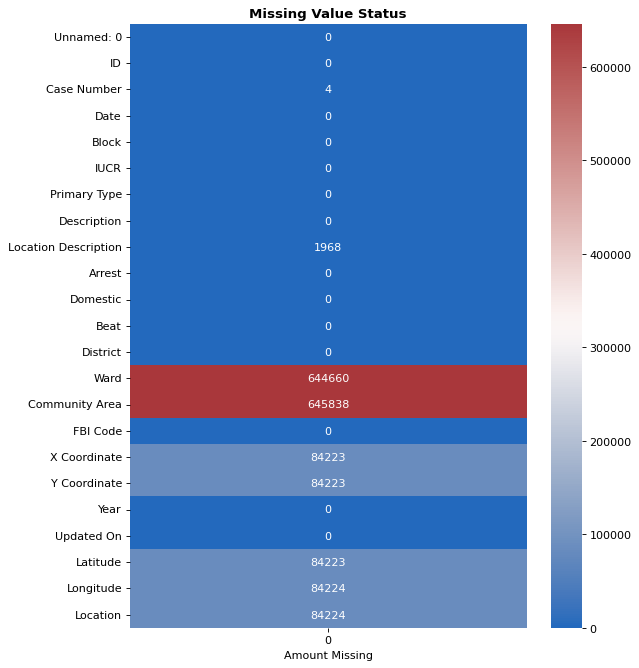

In [11]:
plt.figure(figsize=(8, 10), dpi=80)
plt.title('Missing Value Status',fontweight='bold')
ax = sns.heatmap(dt.isna().sum().to_frame(),annot=True,fmt='d',cmap='vlag')
ax.set_xlabel('Amount Missing')
plt.show()

In [12]:
dt.dropna(inplace=True )

In [13]:
chicago_dt = dt.resample('M').size().reset_index()

In [14]:
chicago_dt

,Date,0
0,2001-01-31,397
1,2001-02-28,177
2,2001-03-31,197
3,2001-04-30,237
4,2001-05-31,219
...,...,...
188,2016-09-30,22402
189,2016-10-31,22530
190,2016-11-30,20428
191,2016-12-31,19070


In [15]:
chicago_dt['Date'] = pd.to_datetime(chicago_dt['Date'])


In [16]:
chicago_dt

,Date,0
0,2001-01-31,397
1,2001-02-28,177
2,2001-03-31,197
3,2001-04-30,237
4,2001-05-31,219
...,...,...
188,2016-09-30,22402
189,2016-10-31,22530
190,2016-11-30,20428
191,2016-12-31,19070


In [17]:
chicago_dt = chicago_dt.rename(columns={ 0:'Number of crimes'})

In [18]:
chicago_dt

,Date,Number of crimes
0,2001-01-31,397
1,2001-02-28,177
2,2001-03-31,197
3,2001-04-30,237
4,2001-05-31,219
...,...,...
188,2016-09-30,22402
189,2016-10-31,22530
190,2016-11-30,20428
191,2016-12-31,19070


In [19]:
chicago_dt.set_index('Date', inplace=True)

In [20]:
chicago_dt.info()
chicago_dt

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 193 entries, 2001-01-31 to 2017-01-31
Data columns (total 1 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Number of crimes  193 non-null    int64
dtypes: int64(1)
memory usage: 3.0 KB


,Number of crimes
Date,
2001-01-31,397
2001-02-28,177
2001-03-31,197
2001-04-30,237
2001-05-31,219
...,...
2016-09-30,22402
2016-10-31,22530
2016-11-30,20428


In [21]:
chicago_dt['Number of crimes'] = chicago_dt['Number of crimes'].apply(int)

In [22]:
chicago_dt.drop_duplicates()

,Number of crimes
Date,
2001-01-31,397
2001-02-28,177
2001-03-31,197
2001-04-30,237
2001-05-31,219
...,...
2016-09-30,22402
2016-10-31,22530
2016-11-30,20428


## Steps of Time series analysis

### 1- Time series plot

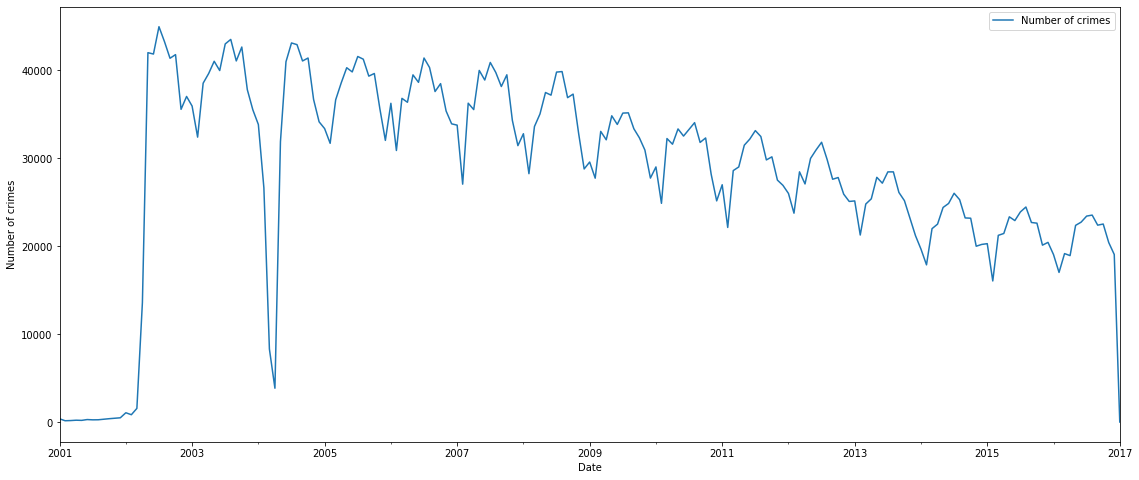

In [23]:
#Time series plot 
chicago_dt.plot(figsize=(19,8) , ylabel='Number of crimes')
plt.show()

#### the series shows the series is not stationary

### 2- Trends, Seasonl, Residual components plot

In [24]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition_mul = seasonal_decompose(chicago_dt,model='multiplicative')
decomposition_add = seasonal_decompose(chicago_dt,model='additive')
#Decomposition of time series using multiplicative model 
trend_mul = decomposition_mul.trend
seasonal_mul = decomposition_mul.seasonal
residual_mul = decomposition_mul.resid
#Decomposition of time series using additive model 
trend_add = decomposition_add.trend
seasonal_add = decomposition_add.seasonal
residual_add = decomposition_add.resid

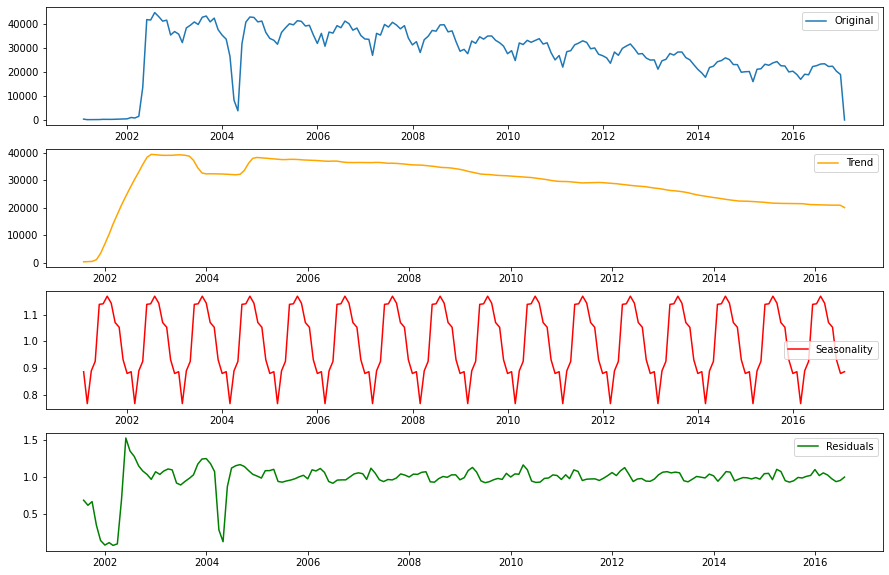

In [25]:
fig, axes = plt.subplots(4, 1)
fig.set_figheight(10)
fig.set_figwidth(15)

axes[0].plot(chicago_dt, label='Original')
axes[0].legend()

axes[1].plot(trend_mul, label='Trend',color="orange")
axes[1].legend()

axes[2].plot(seasonal_mul, label='Seasonality',color='r')
axes[2].legend()

axes[3].plot(residual_mul, label='Residuals',color='g')
axes[3].legend()

plt.show()

### 3- Test of staionarity

In [26]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    
    #Determining rolling statistics
    rolmean = timeseries.rolling(window = 12).mean()
    rolstd = timeseries.rolling(window = 12).std()
    
    #plotting rolling statistics
    orig = plt.plot(timeseries, color = 'blue', label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label = 'Rolling Mean')
    st = plt.plot(rolstd, color = 'black', label = 'Rolling Std')
    plt.legend(loc = 'best' ,fontsize=12)
    plt.title('Rolling  Mean & Standard Deviation')

    plt.show()
    
    #Dickey_Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries)
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key] = value
    print(dfoutput)

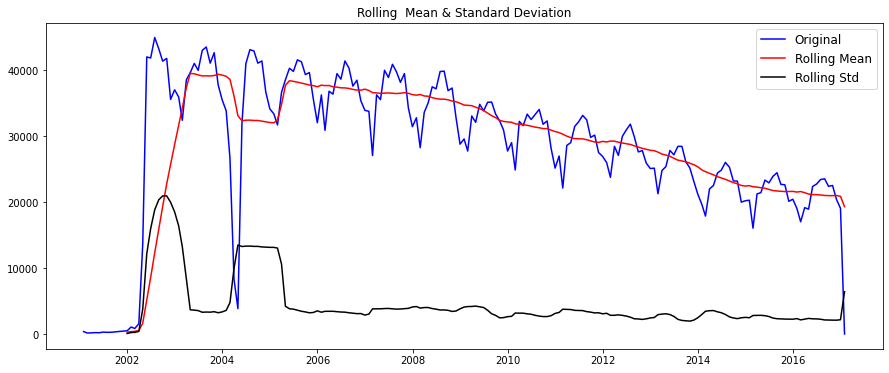

Results of Dickey-Fuller Test:
Test Statistic                 -3.974
p-value                         0.002
#Lags Used                     14.000
Number of Observations Used   178.000
Critical Value (1%)            -3.468
Critical Value (5%)            -2.878
Critical Value (10%)           -2.576
dtype: float64


In [27]:
test_stationarity(chicago_dt['Number of crimes'])
plt.rcParams['figure.figsize'] = [15, 15]

#### p-value is bigger than 0.05 thats mean time series is not stationary

### 4-  Make the Series Stationary (Eliminate trend and seasonality)

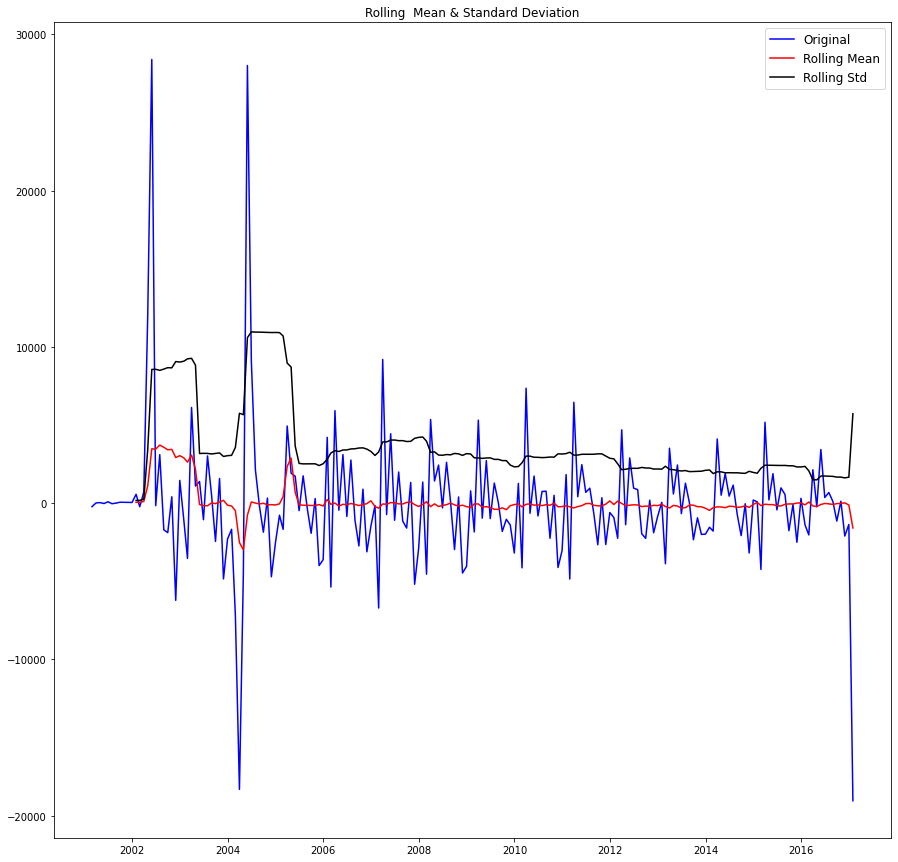

Results of Dickey-Fuller Test:
Test Statistic                 -2.800
p-value                         0.058
#Lags Used                     13.000
Number of Observations Used   178.000
Critical Value (1%)            -3.468
Critical Value (5%)            -2.878
Critical Value (10%)           -2.576
dtype: float64


In [28]:
chicago_dt1 = chicago_dt.diff(periods=1)
chicago_dt1.dropna(inplace=True)
test_stationarity(chicago_dt1)

### Double Exponential (Holt)

In [29]:
train=chicago_dt[0:int(len(chicago_dt)*0.80)] 
test=chicago_dt[int(len(chicago_dt)*0.80):]

#Split the data for 21 month test

train_log = np.log10(train['Number of crimes'])

In [30]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [31]:
model_chicago = ExponentialSmoothing(np.asarray(train['Number of crimes']),seasonal_periods=24, trend='add',seasonal='mul').fit(optimized=True)

In [32]:
chicago_Holt = test.copy()

In [33]:
chicago_Holt['Holt']=model_chicago.forecast(len(test['Number of crimes']))

In [34]:
mean_absolute_percentage_error(test['Number of crimes'],chicago_Holt['Holt'])

233.12233403486437

In [35]:
model_chicago.params

{'smoothing_level': 0.995,
 'smoothing_trend': 0.21321428571428575,
 'smoothing_seasonal': 0.0050000000000000044,
 'damping_trend': nan,
 'initial_level': 13287.3361111111,
 'initial_trend': 1664.0055555555573,
 'initial_seasons': array([0.93573237, 0.83306442, 1.00298223, 1.00424746, 1.0746364 ,
        1.05250293, 1.11140574, 1.10882837, 1.0577304 , 1.07474564,
        0.97131408, 0.8898469 , 0.71797968, 0.59779254, 0.55712305,
        0.68260623, 1.2301252 , 1.2509191 , 1.30507388, 1.25399813,
        1.16316912, 1.16014457, 1.01042102, 0.95361054]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

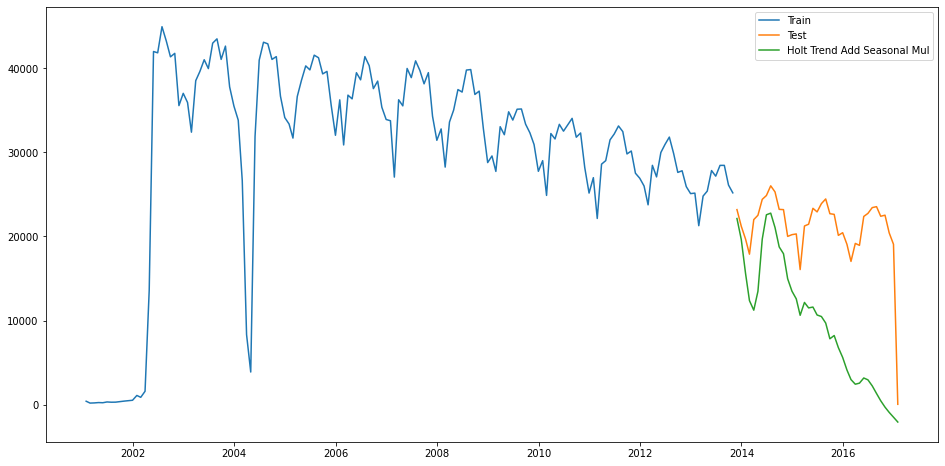

In [36]:
chicago_Holt['Pax'] = model_chicago.forecast(len(test['Number of crimes']))
plt.figure(figsize=(16,8))
plt.plot(train['Number of crimes'], label='Train')
plt.plot(test['Number of crimes'], label='Test')
plt.plot(chicago_Holt['Holt'], label='Holt Trend Add Seasonal Mul')
plt.legend(loc=0)

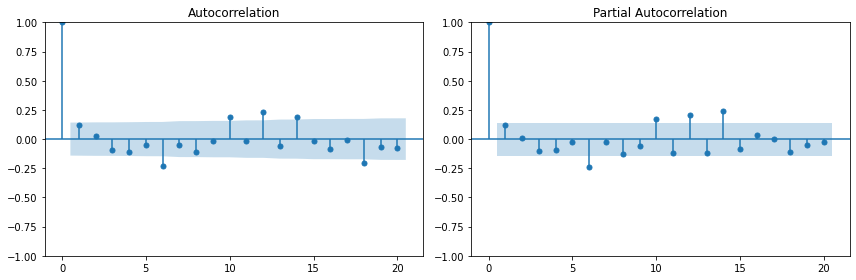

In [37]:
fig, axes = plt.subplots(1, 2)
fig.set_figwidth(12)
fig.set_figheight(4)
smt.graphics.plot_acf(chicago_dt1, lags=20, ax=axes[0])
smt.graphics.plot_pacf(chicago_dt1, lags=20, ax=axes[1])
plt.tight_layout()

In [38]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [39]:
best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
temp_model = None
train_log = np.log10(train['Number of crimes'])

In [40]:
for param in pdq: #Non-Seasonal
    for param_seasonal in seasonal_pdq:
        
        try:
            temp_model = sm.tsa.statespace.SARIMAX(train_log,
                                             order = param,
                                             seasonal_order = param_seasonal)
            results = temp_model.fit(disp=0)

            # print("SARIMAX{}x{}12 - AIC:{}".format(param, param_seasonal, results.aic))
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal #Store the best param values : AIC, P, D, Q [Non-S / Seas]
        except:
            #print("Unexpected error:", sys.exc_info()[0])
            continue
print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

Best SARIMAX(1, 1, 1)x(1, 0, 1, 12)12 model - AIC:-183.67884503543524


In [41]:
mod = sm.tsa.statespace.SARIMAX(train_log,
                                order=(1,1,1),
                                seasonal_order=(1, 0, 1, 12),
                                enforce_stationarity=True)

best_results = mod.fit(method='cg')

print(best_results.summary().tables[1])

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3271      0.075     -4.371      0.000      -0.474      -0.180
ma.L1         -0.1902      0.063     -3.008      0.003      -0.314      -0.066
ar.S.L12       0.0186      0.417      0.045      0.964      -0.798       0.835
ma.S.L12       0.0318      0.412      0.077      0.938      -0.776       0.839
sigma2         0.0161      0.001     31.457      0.000       0.015       0.017


In [42]:
best_results.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,-0.3271,0.075,-4.371,0.000,-0.474,-0.180
ma.L1,-0.1902,0.063,-3.008,0.003,-0.314,-0.066
ar.S.L12,0.0186,0.417,0.045,0.964,-0.798,0.835
ma.S.L12,0.0318,0.412,0.077,0.938,-0.776,0.839
sigma2,0.0161,0.001,31.457,0.000,0.015,0.017


In [43]:
chicago_dt.tail(40)

,Number of crimes
Date,
2013-10-31,25187
2013-11-30,23192
2013-12-31,21214
2014-01-31,19676
2014-02-28,17892
2014-03-31,22005
2014-04-30,22519
2014-05-31,24413
2014-06-30,24867


In [44]:
pred_dynamic = best_results.get_prediction(start=pd.to_datetime('2013-11-30'), dynamic=True, full_results=True)

In [45]:
pred_dynamic_ci = pred_dynamic.conf_int()

In [46]:
pred_dynamic

In [47]:
pred99 = best_results.get_forecast(steps=24, alpha=0.1)

In [48]:
# Extract the predicted and true values of our time series
crimes_ts_forecasted = pred_dynamic.predicted_mean
testCopy = test.copy()
testCopy['Crimes_Forecast'] = np.power(10, pred99.predicted_mean)

In [49]:
# Compute the root mean square error
mse = ((testCopy['Number of crimes'] - testCopy['Crimes_Forecast'])** 2).mean()
rmse = np.sqrt(mse)
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 3)))

The Root Mean Squared Error of our forecasts is 4088.951


In [50]:
mape = np.mean(np.abs(testCopy['Number of crimes'] - testCopy['Crimes_Forecast'])/np.abs(testCopy['Number of crimes']))

In [51]:
mape

0.16830805803475216

#### Around 16.8% MAPE implies the model is about 83.2% accurate in predicting the next observations. 

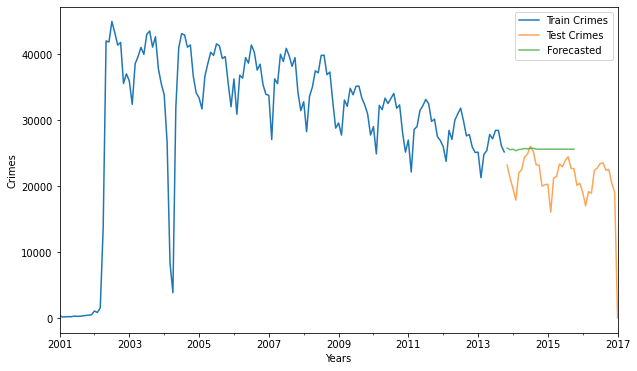

In [52]:
axis = train['Number of crimes'].plot(label='Train Crimes', figsize=(10, 6))
testCopy['Number of crimes'].plot(ax=axis, label='Test Crimes', alpha=0.7)
testCopy['Crimes_Forecast'].plot(ax=axis, label='Forecasted ', alpha=0.7)
axis.set_xlabel('Years')
axis.set_ylabel('Crimes')
plt.legend(loc='best')
plt.show()
plt.close()

## Forecast crimes using the best fit ARIMA model

In [53]:
# Get forecast 36 steps (3 years) ahead in future
n_steps = 36
pred_uc_99 = best_results.get_forecast(steps=36, alpha=0.01) # alpha=0.01 signifies 99% confidence interval
pred_uc_95 = best_results.get_forecast(steps=36, alpha=0.05) # alpha=0.05 95% CI

# Get confidence intervals 95% & 99% of the forecasts
pred_ci_99 = pred_uc_99.conf_int()
pred_ci_95 = pred_uc_95.conf_int()

In [54]:
n_steps = 36
idx = pd.date_range(chicago_dt.index[-1], periods=n_steps, freq='MS')
fc_95 = pd.DataFrame(np.column_stack([np.power(10, pred_uc_95.predicted_mean), np.power(10, pred_ci_95)]), 
                     index=idx, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])
fc_99 = pd.DataFrame(np.column_stack([np.power(10, pred_ci_99)]), 
                     index=idx, columns=['lower_ci_99', 'upper_ci_99'])
fc_all = fc_95.combine_first(fc_99)
fc_all = fc_all[['forecast', 'lower_ci_95', 'upper_ci_95', 'lower_ci_99', 'upper_ci_99']] # just reordering columns
fc_all.head()

,forecast,lower_ci_95,upper_ci_95,lower_ci_99,upper_ci_99
2017-02-01,25783.687,14538.327,45727.304,14538.327,45727.304
2017-03-01,25517.325,13506.275,48209.730,13506.275,48209.730
2017-04-01,25595.153,12239.432,53524.697,12239.432,53524.697
2017-05-01,25359.770,11246.933,57181.628,11246.933,57181.628
2017-06-01,25557.086,10536.611,61990.011,10536.611,61990.011


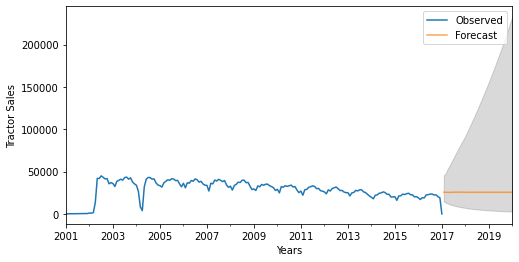

In [55]:
# plot the forecast along with the confidence band
axis = chicago_dt['Number of crimes'].plot(label='Observed', figsize=(8, 4))
fc_all['forecast'].plot(ax=axis, label='Forecast', alpha=0.7)
axis.fill_between(fc_all.index, fc_all['lower_ci_95'], fc_all['upper_ci_95'], color='k', alpha=.15)
axis.set_xlabel('Years')
axis.set_ylabel('Tractor Sales')
plt.legend(loc='best')
plt.show()

### Plot ACF and PACF for residuals of ARIMA model¶


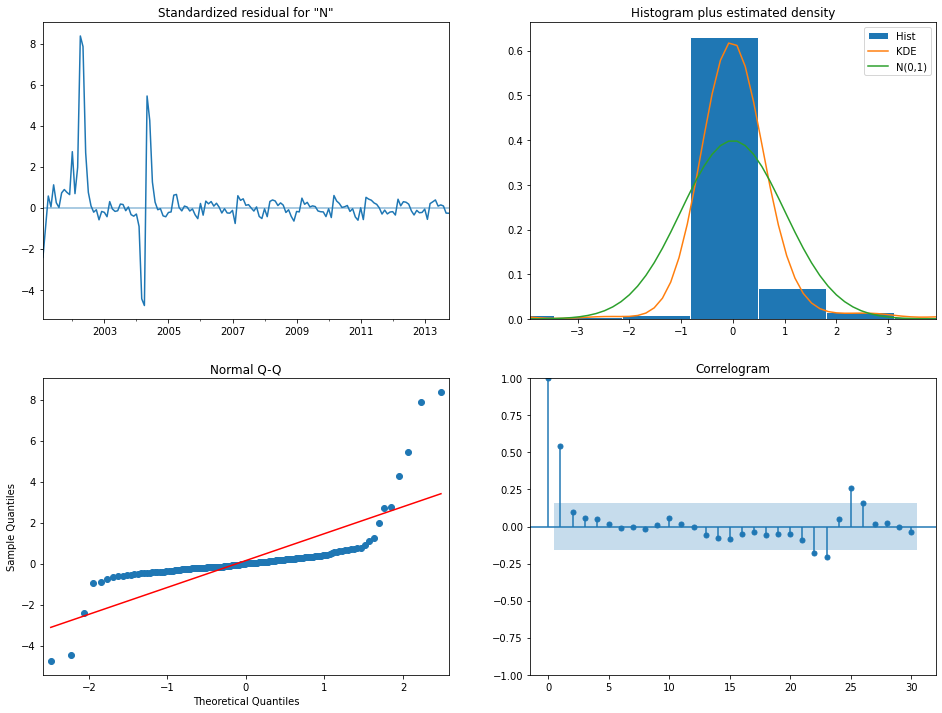

In [56]:
best_results.plot_diagnostics(lags=30, figsize=(16,12))
plt.show()

### Overall, the model seems to be a good fit. 

In [57]:
#=======================================

In [58]:
%pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 1.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [59]:
import pmdarima as pm

In [60]:
# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(chicago_dt, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=3519.927, Time=2.42 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=3893.635, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=3542.529, Time=1.71 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=3701.610, Time=1.38 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=3894.278, Time=0.02 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=3596.388, Time=0.11 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=3513.456, Time=1.46 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=3522.855, Time=1.73 sec
 ARIMA(1,0,1)(2,1,1)[12] intercept   : AIC=3517.601, Time=5.37 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=3514.923, Time=4.92 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=3515.875, Time=4.85 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=3517.742, Time=3.79 sec
 ARIMA(1,0,1)(2,1,2)[12] intercept   : AIC=3519.312, Time=6.39 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=3702.873, Time=2.38 sec
 ARIMA(1,0,0)(1,1,1

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  193
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 12)   Log Likelihood               -1750.736
Date:                            Fri, 03 Jun 2022   AIC                           3511.472
Time:                                    23:25:25   BIC                           3527.465
Sample:                                         0   HQIC                          3517.956
                                            - 193                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9433      0.026     36.974      0.000       0.893       0.993
ma.L1          0.3761      0.056      6.739      0.000       0.267       0.485
ar.S.L12      -0.3374      0.045     -7.424      0.000      -0.426      -0.248
ma.S.L12      -0.5451      0.055     -9.883      0.000      -0.653      -0.437
sigma2      1.434e+07   6.71e+05     21.370      0.000     1.3e+07    1.57e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):              1369.47
Prob(Q):                              0.67   Prob(JB):                         0.00
Heteroskedasticity (H):               0.22   Skew:                             0.98
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

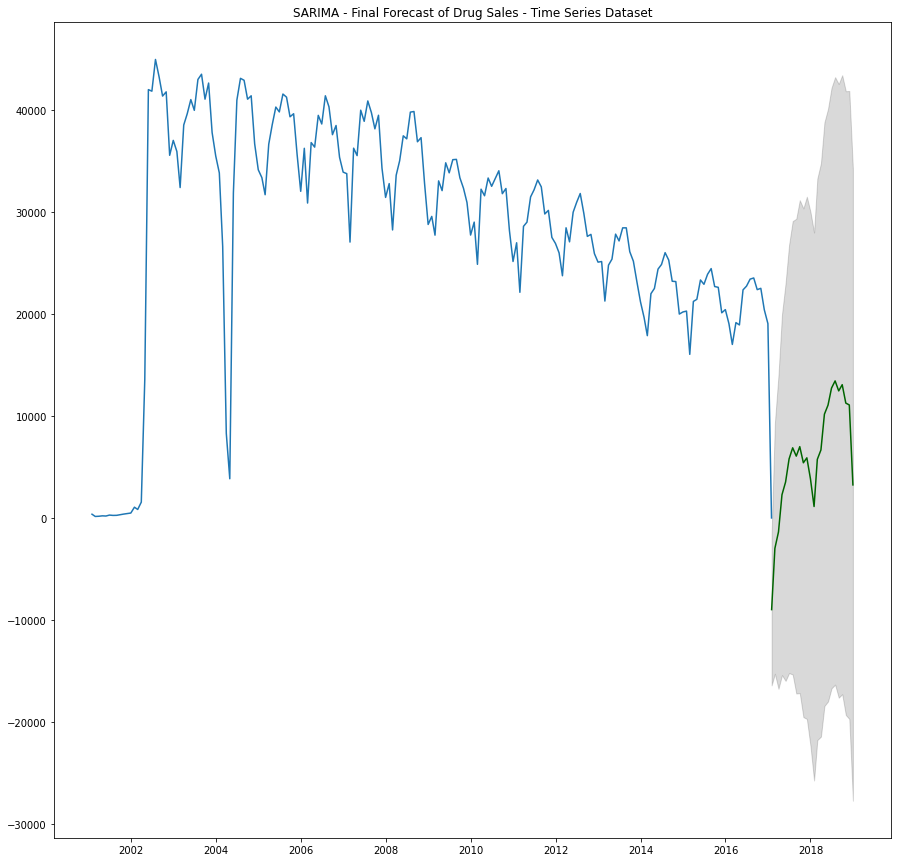

In [61]:
# Forecast
n_periods = 24
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(chicago_dt.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(chicago_dt)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA - Final Forecast of Drug Sales - Time Series Dataset")
plt.show()

In [62]:
#===============================================

In [63]:
# Compute Seasonal Index
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

# multiplicative seasonal component
result_mul = seasonal_decompose(chicago_dt['Number of crimes'][-36:],   # 3 years
                                model='multiplicative', 
                                extrapolate_trend='freq')

seasonal_index = result_mul.seasonal[-12:].to_frame()
seasonal_index['month'] = pd.to_datetime(seasonal_index.index).month

# merge with the base data
chicago_dt['month'] = chicago_dt.index.month
df = pd.merge(chicago_dt, seasonal_index, how='left', on='month')
df.columns = ['value', 'month', 'seasonal_index']
df.index = chicago_dt.index  # reassign the index

In [64]:
# SARIMAX Model
sxmodel = pm.auto_arima(chicago_dt[['Number of crimes']], exogenous=df[['seasonal_index']],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=None, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

sxmodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=3521.943, Time=2.38 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=3895.635, Time=0.07 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=3544.523, Time=2.50 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=3703.580, Time=1.86 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=4656.825, Time=0.06 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=3598.388, Time=0.10 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=3515.453, Time=1.80 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=3524.851, Time=2.16 sec
 ARIMA(1,0,1)(2,1,1)[12] intercept   : AIC=3518.828, Time=6.82 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=3516.944, Time=5.74 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=3517.872, Time=5.49 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=3519.736, Time=4.57 sec
 ARIMA(1,0,1)(2,1,2)[12] intercept   : AIC=3521.561, Time=6.90 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=3704.842, Time=2.55 sec
 ARIMA(1,0,0)(1,1,1

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  193
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 12)   Log Likelihood               -1750.735
Date:                            Fri, 03 Jun 2022   AIC                           3513.469
Time:                                    23:27:16   BIC                           3532.660
Sample:                                01-31-2001   HQIC                          3521.250
                                     - 01-31-2017                                         
Covariance Type:                              opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
seasonal_index     9.1168   8715.742      0.001      0.999   -1.71e+04    1.71e+04
ar.L1              0.9433      0.030     31.520      0.000       0.885       1.002
ma.L1              0.3761      0.056      6.760      0.000       0.267       0.485
ar.S.L12          -0.3375      0.046     -7.328      0.000      -0.428      -0.247
ma.S.L12          -0.5451      0.056     -9.753      0.000      -0.655      -0.436
sigma2          1.434e+07     56.839   2.52e+05      0.000    1.43e+07    1.43e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):              1369.37
Prob(Q):                              0.67   Prob(JB):                         0.00
Heteroskedasticity (H):               0.22   Skew:                             0.98
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.97e+25. Standard errors may be unstable.
"""